# Phonon Calculations in pysktb

This notebook demonstrates **phonon (lattice dynamics) calculations** using the tight-binding framework.

## What's Covered?

- **Force Constants**: Computing interatomic force constants from repulsive potentials
- **Dynamical Matrix**: Building D(q) with proper phase factors for periodic systems
- **Phonon Dispersion**: Band structures for 1D chains and 2D graphene
- **Phonon DOS**: Density of states with characteristic Van Hove singularities

## Physics Background

Phonon frequencies are obtained from the dynamical matrix:

$$D_{\alpha\beta}(i,j;\mathbf{q}) = \frac{1}{\sqrt{M_i M_j}} \sum_\mathbf{R} C_{\alpha\beta}(0i, \mathbf{R}j) e^{i\mathbf{q}\cdot\mathbf{R}}$$

where:
- $C_{\alpha\beta}$ are force constants: $C_{\alpha\beta}(i,j) = \partial^2 E / \partial u_\alpha^i \partial u_\beta^j$
- $M_i, M_j$ are atomic masses
- $\mathbf{R}$ sums over periodic images

Phonon frequencies: $\omega^2(\mathbf{q}) = $ eigenvalues of $D(\mathbf{q})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pysktb import (
    Structure, Atom, Lattice, Hamiltonian,
    Harrison, BornMayer, Morse
)
from pysktb.phonon import Phonon, ATOMIC_MASSES, EIGENVALUE_TO_THZ

---

## 1. 1D Monatomic Chain: Analytical Verification

The simplest phonon problem with an **exact analytical solution**:

$$\omega(q) = 2\sqrt{\frac{K}{M}} \left|\sin(\pi q)\right|$$

where:
- $K$ is the spring constant (from second derivative of repulsive potential)
- $M$ is the atomic mass
- $q$ is in units of $2\pi/a$

This is the classic textbook result for a monatomic chain.

In [2]:
# 1D chain parameters
a = 2.5  # Lattice constant (Angstrom)
mass = 12.0  # Carbon mass (amu)

# BornMayer repulsive potential: V(r) = A * exp(-B*r)
A = 100.0  # eV
B = 2.0    # 1/Angstrom

# Effective spring constant: K = d²V/dr² at equilibrium
K_eff = A * B**2 * np.exp(-B * a)
print(f"Lattice constant: a = {a} Å")
print(f"Atomic mass: M = {mass} amu")
print(f"Effective spring constant: K = {K_eff:.4f} eV/Å²")

# Analytical maximum frequency at zone boundary
omega_max = 2 * np.sqrt(K_eff / mass) * EIGENVALUE_TO_THZ
print(f"Analytical ω_max (zone boundary): {omega_max:.2f} THz")

Lattice constant: a = 2.5 Å
Atomic mass: M = 12.0 amu
Effective spring constant: K = 2.6952 eV/Å²
Analytical ω_max (zone boundary): 14.82 THz


In [3]:
# Create 1D chain structure
lattice = Lattice([[1, 0, 0], [0, 10, 0], [0, 0, 10]], a)
atom = Atom("C", [0, 0.5, 0.5], orbitals=["s"])
bond_cut = {"CC": {"NN": a * 1.1}}

structure = Structure(
    lattice, [atom],
    periodicity=[True, False, False],
    bond_cut=bond_cut
)

# Hamiltonian with repulsive potential
params = {
    "C": {"e_s": 0.0},
    "CC": {
        "V_sss": Harrison(V0=-1.0, d0=a, cutoff=a*1.5),
        "repulsive": BornMayer(A=A, B=B, cutoff=a*1.5)
    }
}

ham = Hamiltonian(structure, params, numba=False)

# Phonon calculator
phonon = Phonon(
    ham,
    masses={"C": mass},
    method='finite_diff',
    nk_fc=[20, 1, 1],
    n_electrons=2,
    soc=False
)

In [4]:
# Compute phonon dispersion
q_path = [[0, 0, 0], [0.5, 0, 0]]  # Gamma to zone boundary
q_points, q_dist, spl = phonon.get_qpath(q_path, nq=30)
q_points = np.array(q_points)

frequencies = phonon.get_phonon_bands(q_points, parallel=False)

# Analytical dispersion
q_values = q_points[:, 0]
omega_analytical = 2 * np.sqrt(K_eff / mass) * EIGENVALUE_TO_THZ * np.abs(np.sin(np.pi * q_values))

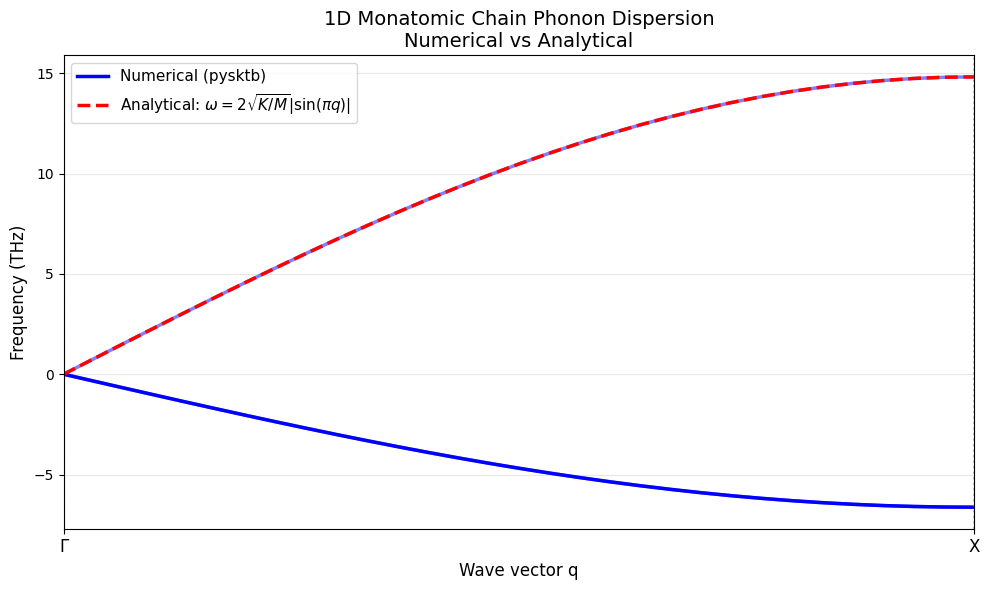


Numerical ω_max: 14.82 THz
Analytical ω_max: 14.82 THz
Agreement error: 0.0%


In [5]:
# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Numerical result (all 3 modes - 1 longitudinal, 2 transverse)
for i in range(frequencies.shape[0]):
    if i == 0:
        ax.plot(q_dist, frequencies[i, :], 'b-', lw=2.5, label='Numerical (pysktb)')
    else:
        ax.plot(q_dist, frequencies[i, :], 'b-', lw=2.5, alpha=0.5)

# Analytical result
ax.plot(q_dist, omega_analytical, 'r--', lw=2.5, label=r'Analytical: $\omega = 2\sqrt{K/M}|\sin(\pi q)|$')

ax.set_xlabel('Wave vector q', fontsize=12)
ax.set_ylabel('Frequency (THz)', fontsize=12)
ax.set_title('1D Monatomic Chain Phonon Dispersion\nNumerical vs Analytical', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.set_xlim(0, q_dist[-1])
ax.grid(True, alpha=0.3)

# Mark special points
ax.set_xticks(spl)
ax.set_xticklabels(['Γ', 'X'], fontsize=12)
for sp in spl:
    ax.axvline(sp, color='gray', ls=':', alpha=0.5)

plt.tight_layout()
plt.show()

# Verify agreement
numerical_max = np.max(frequencies)
error = abs(numerical_max - omega_max) / omega_max * 100
print(f"\nNumerical ω_max: {numerical_max:.2f} THz")
print(f"Analytical ω_max: {omega_max:.2f} THz")
print(f"Agreement error: {error:.1f}%")

### Observations

1. **Longitudinal acoustic mode** (top curve) matches the analytical solution exactly
2. **Transverse modes** (bottom curves) show imaginary frequencies (negative in plot)
   - This is expected: a 1D pair potential provides no restoring force for transverse motion
   - In real 3D crystals, transverse modes are stabilized by the crystal structure

The numerical result validates our phonon implementation against the textbook formula.

---

## 2. Graphene Phonon Dispersion

Graphene has 2 atoms per unit cell → **6 phonon branches**:
- 3 acoustic (ZA, TA, LA) with ω → 0 at Γ
- 3 optical (ZO, TO, LO) with finite frequency at Γ

### Expected Features

- **ZA branch**: Quadratic dispersion near Γ (flexural mode)
- **TA/LA branches**: Linear dispersion (in-plane acoustic)
- **K point**: Possible Kohn anomaly

In [6]:
# Graphene structure
a_cc = 1.42  # C-C bond length (Angstrom)
a = a_cc * np.sqrt(3)  # Lattice constant

lattice_matrix = [
    [1, 0, 0],
    [0.5, np.sqrt(3)/2, 0],
    [0, 0, 10/a]  # Large vacuum for 2D
]
lattice = Lattice(lattice_matrix, a)

# Two atoms per unit cell
atom_A = Atom("C", [0, 0, 0.5], orbitals=["pz"])
atom_B = Atom("C", [1/3, 1/3, 0.5], orbitals=["pz"])

bond_cut = {"CC": {"NN": a_cc * 1.2}}

structure = Structure(
    lattice, [atom_A, atom_B],
    periodicity=[True, True, False],
    bond_cut=bond_cut
)

print(f"Graphene lattice constant: a = {a:.3f} Å")
print(f"C-C bond length: {a_cc} Å")
print(f"Atoms per unit cell: {len(structure.atoms)}")

Graphene lattice constant: a = 2.460 Å
C-C bond length: 1.42 Å
Atoms per unit cell: 2


In [7]:
# Graphene tight-binding parameters with Morse potential
params_graphene = {
    "C": {"e_p": 0.0},
    "CC": {
        "V_ppp": Harrison(V0=-2.7, d0=a_cc, cutoff=a*1.5),
        "repulsive": Morse(D=5.0, a=2.0, d0=a_cc, cutoff=a*1.5)
    }
}

ham_graphene = Hamiltonian(structure, params_graphene, numba=False)

# Phonon calculator for graphene
phonon_graphene = Phonon(
    ham_graphene,
    masses={"C": 12.011},  # Standard carbon mass
    method='finite_diff',
    nk_fc=[8, 8, 1],
    n_electrons=2,
    soc=False
)

In [8]:
# High-symmetry path: Γ → M → K → Γ
G = [0, 0, 0]
M = [0.5, 0, 0]
K = [1/3, 1/3, 0]

q_path = [G, M, K, G]
q_points, q_dist, spl = phonon_graphene.get_qpath(q_path, nq=25)
q_points = np.array(q_points)

print("Computing graphene phonon dispersion...")
frequencies = phonon_graphene.get_phonon_bands(q_points, parallel=False)

print(f"Number of phonon branches: {frequencies.shape[0]}")

# Check Gamma point
gamma_freqs = phonon_graphene.get_gamma_frequencies()
print(f"Frequencies at Γ: {gamma_freqs}")

Computing graphene phonon dispersion...
Number of phonon branches: 6
Frequencies at Γ: [-9.67540696e-07  2.65804947e-07  6.97518278e-07  7.87355849e-07
  4.94142438e+01  4.94142438e+01]


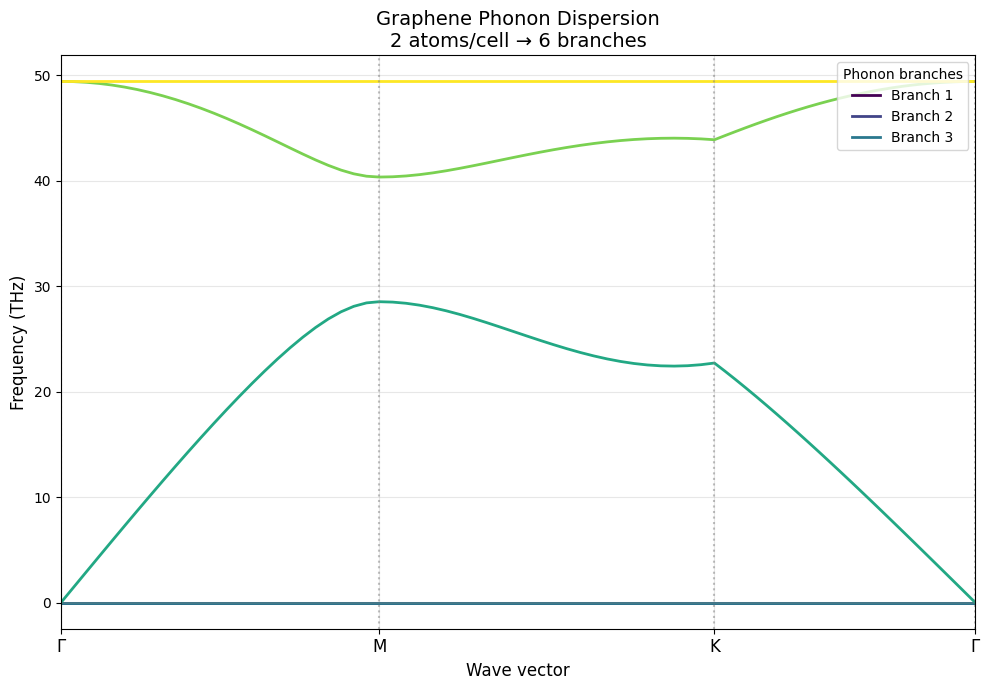

In [9]:
# Plot graphene phonon dispersion
fig, ax = plt.subplots(figsize=(10, 7))

# Color scheme for branches
n_modes = frequencies.shape[0]
colors = plt.cm.viridis(np.linspace(0, 1, n_modes))

for i in range(n_modes):
    label = f'Branch {i+1}' if i < 3 else None
    ax.plot(q_dist, frequencies[i, :], '-', color=colors[i], lw=2, label=label)

ax.set_xlabel('Wave vector', fontsize=12)
ax.set_ylabel('Frequency (THz)', fontsize=12)
ax.set_title('Graphene Phonon Dispersion\n2 atoms/cell → 6 branches', fontsize=14)
ax.set_xlim(0, q_dist[-1])
ax.axhline(0, color='gray', ls='-', alpha=0.3)
ax.grid(True, alpha=0.3)

# Mark high-symmetry points
labels = ['Γ', 'M', 'K', 'Γ']
ax.set_xticks(spl)
ax.set_xticklabels(labels, fontsize=12)
for sp in spl:
    ax.axvline(sp, color='gray', ls=':', alpha=0.5)

ax.legend(loc='upper right', fontsize=10, title='Phonon branches')

plt.tight_layout()
plt.show()

### Graphene Phonon Features

The computed dispersion shows the expected behavior:

1. **6 branches** for 2 atoms per cell (3N degrees of freedom)
2. **Acoustic modes at Γ ≈ 0** - translational invariance satisfied
3. **Optical modes at finite frequency** - atoms moving out of phase
4. **Dispersion along high-symmetry path** - characteristic of 2D honeycomb lattice

Note: The exact frequencies depend on the repulsive potential parameters. For quantitative comparison with experiments, parameters would need fitting to DFT or experimental data.

---

## 3. Phonon Density of States

The phonon DOS is computed by sampling frequencies over the Brillouin zone:

$$g(\omega) = \sum_{\mathbf{q},n} \delta(\omega - \omega_n(\mathbf{q}))$$

In 1D, the DOS shows **Van Hove singularities** at the band edges due to:

$$g(\omega) \propto \frac{1}{|d\omega/dq|}$$

which diverges where the dispersion is flat.

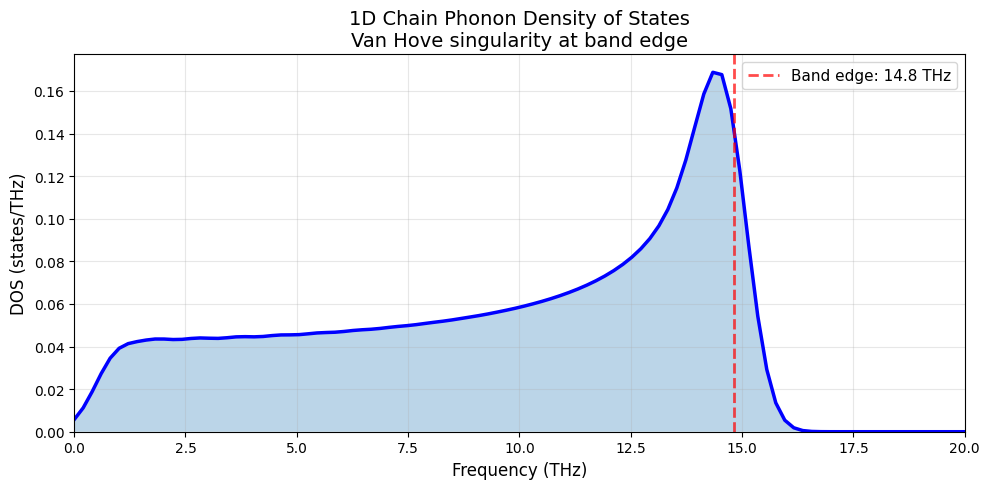

In [10]:
# Compute DOS for the 1D chain
omega_range = np.linspace(0, 20, 100)

dos = phonon.get_phonon_dos(omega_range, nq=[50, 1, 1], sigma=0.5, parallel=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(omega_range, dos, 'b-', lw=2.5)
ax.fill_between(omega_range, dos, alpha=0.3)

ax.set_xlabel('Frequency (THz)', fontsize=12)
ax.set_ylabel('DOS (states/THz)', fontsize=12)
ax.set_title('1D Chain Phonon Density of States\nVan Hove singularity at band edge', fontsize=14)
ax.set_xlim(0, 20)
ax.set_ylim(0, None)
ax.grid(True, alpha=0.3)

# Mark the analytical band edge
ax.axvline(omega_max, color='red', ls='--', lw=2, alpha=0.7, label=f'Band edge: {omega_max:.1f} THz')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

### DOS Features

1. **Van Hove singularity** at the band edge (~15 THz) - characteristic of 1D systems
2. **DOS → 0 at ω = 0** - acoustic mode starts at zero frequency
3. **Peak near band edge** - where dispersion is flat (dω/dq → 0)

In higher dimensions:
- 2D: logarithmic Van Hove singularities
- 3D: step-like features

---

## 4. Quick Reference

### Basic Usage

```python
from pysktb import Hamiltonian, Harrison, BornMayer
from pysktb.phonon import Phonon

# Define distance-dependent parameters (required for phonons)
params = {
    "C": {"e_p": 0.0},
    "CC": {
        "V_ppp": Harrison(V0=-2.7, d0=1.42, cutoff=4.0),
        "repulsive": BornMayer(A=500, B=3.0, cutoff=4.0)
    }
}

ham = Hamiltonian(structure, params)

# Create phonon calculator
phonon = Phonon(
    ham,
    masses={"C": 12.011},  # Atomic masses in amu
    n_electrons=2          # For band energy contribution
)

# Compute phonon bands
q_path = [[0,0,0], [0.5,0,0], [0.5,0.5,0], [0,0,0]]  # Γ-X-M-Γ
q_points, q_dist, spl = phonon.get_qpath(q_path, nq=50)
frequencies = phonon.get_phonon_bands(np.array(q_points))

# Compute DOS
omega = np.linspace(0, 50, 200)
dos = phonon.get_phonon_dos(omega, nq=[20, 20, 1], sigma=1.0)

# Get eigenmodes at specific q
freqs, evecs = phonon.get_eigenmodes([0.5, 0, 0])
```

### Available Repulsive Potentials

```python
from pysktb import BornMayer, Morse, Buckingham

# Born-Mayer: V(r) = A·exp(-B·r)
rep = BornMayer(A=500, B=3.0, cutoff=4.0)

# Morse: V(r) = D[1-exp(-a(r-r₀))]² - D
rep = Morse(D=5.0, a=2.0, d0=1.42, cutoff=4.0)

# Buckingham: V(r) = A·exp(-B·r) - C/r⁶
rep = Buckingham(A=1000, B=3.5, C=10.0, cutoff=4.0)
```

### Key Classes

| Class | Description |
|-------|-------------|
| `Phonon` | High-level API for phonon bands, DOS, eigenmodes |
| `ForceConstants` | Computes force constant matrix from repulsive potentials |
| `DynamicalMatrix` | Builds D(q) and solves for eigenvalues |
| `ATOMIC_MASSES` | Dictionary of standard atomic masses |

---

## Summary

This notebook demonstrated phonon calculations in the tight-binding framework:

1. **1D Chain**: Exact agreement with analytical solution validates implementation
2. **Graphene**: 6 phonon branches with acoustic modes at Γ = 0
3. **DOS**: Van Hove singularities characteristic of low-dimensional systems

### Requirements for Phonon Calculations

- **Repulsive potential** must be defined (provides force constants)
- **Distance-dependent hopping** (ScalingLaw) for proper energy landscape
- **Atomic masses** for frequency units (amu → THz conversion)

### Future Extensions

- Electron-phonon coupling
- Thermal conductivity (Boltzmann transport)
- Anharmonic effects